In [1]:
from Summary_Project import analysis, results
from skbio.diversity import beta_diversity, alpha
from skbio.diversity.alpha import shannon
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from skbio.stats.composition import ancom, multiplicative_replacement
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import itertools
from statsmodels.stats.power import TTestIndPower
from sklearn.metrics import roc_auc_score
from scipy.spatial import cKDTree
from tableone import TableOne
from IPython.display import display
import os
import warnings
from skbio import DistanceMatrix

In [2]:
IBD_1000 = results["IBD_1000"]
IBD_1000_T = results["IBD_1000_T"]

Eran_Elinav = results['Eran_Elinav']
Eran_Elinav_T = results['Eran_Elinav_T']

Gevers = results['Gevers']
#Gevers_T = results['Gevers_T']

HMP1 = results['HMP1']
HMP1_T = results['HMP1_T']

HMP2 = results['HMP2']
HMP2_T = results['HMP2_T']

HMP2_pilot = results['HMP2_pilot']
HMP2_pilot_T = results['HMP2_pilot_T']

HMP3 = results['HMP3']
HMP3_T = results['HMP3_T']

ibdmdb = results['ibdmdb']
ibdmdb_T = results['ibdmdb_T']

ibdmdb2 = results['ibdmdb2']
ibdmdb2_T = results['ibdmdb2_T']

Lewis = results['Lewis']
Lewis_T = results['Lewis_T']

MetaHit = results['MetaHit']
MetaHit_T = results['MetaHit_T']

MetaHit2 = results['MetaHit2']
#MetaHit2_T = results['MetaHit2_T']

disease_counts = results['disease_counts']

In [3]:
# 35 Metaphlan control samples are missing
ID_Eran_Elinav_C = Eran_Elinav.loc[Eran_Elinav['Disease'] == 'nonIBD', 'index'].values
Eran_Elinav_C = Eran_Elinav_T.loc[Eran_Elinav_T.index.intersection(ID_Eran_Elinav_C)]

# ID_Gevers_C = Gevers.loc[Gevers["Diagnosis"] == "nonIBD", ...].values - is missing  

ID_HMP1_C = HMP1.loc[HMP1["study design"] == 'nonIBD', 'index'].values
HMP1_C = HMP1_T.loc[HMP1_T.index.intersection(ID_HMP1_C)]

ID_HMP2_C = HMP2.loc[HMP1["study design"] == 'nonIBD', 'index'].values
HMP2_C = HMP2_T.loc[HMP2_T.index.intersection(ID_HMP2_C)]


ID_HMP2_pilot_C = HMP2_pilot.loc[HMP2_pilot["diagnosis"] == 'nonIBD', 'index'].values
HMP2_pilot_C = HMP2_pilot_T.loc[HMP2_pilot_T.index.intersection(ID_HMP2_pilot_C)]

ID_HMP3_C = HMP3.loc[HMP3["isolation_source"] == 'GUT', 'index'].values
HMP3_C = HMP3_T.loc[HMP3_T.index.intersection(ID_HMP3_C)]

# 2 Metaphlan control samples are missing
ID_ibdmdb_C = ibdmdb.loc[ibdmdb["diagnosis"] == 'nonIBD', 'index'].values
ibdmdb_C = ibdmdb_T.loc[ibdmdb_T.index.intersection(ID_ibdmdb_C)]

# 1 Metaphlan control samples are missing
ID_ibdmdb2_C = ibdmdb2.loc[ibdmdb2["diagnosis"] == 'nonIBD', 'index'].values
ibdmdb2_C = ibdmdb2_T.loc[ibdmdb2_T.index.intersection(ID_ibdmdb2_C)]

ID_Lewis_C = Lewis.loc[Lewis["diagnosis"] == 'nonIBD', 'index'].values
Lewis_C = Lewis_T.loc[Lewis_T.index.intersection(ID_Lewis_C)]

ID_MetaHit_C = MetaHit.loc[MetaHit["diagnosis"] == 'nonIBD', 'index'].values
MetaHit_C = MetaHit_T.loc[MetaHit_T.index.intersection(ID_MetaHit_C)]

# ID_MetaHit2_C = MetaHit2.loc[MetaHit2["diagnosis"] == "nonIBD", ...].values - is missing  

In [4]:
df_list_T = [("Eran Elinav" ,Eran_Elinav_C), ("Ibdmdb", ibdmdb_C), ("Ibdmdb2", ibdmdb2_C), ("HMP1", HMP1_C), ("HMP2",HMP2_C),
          ("HMP2 pilot", HMP2_pilot_C),("HMP3" , HMP3_C), ("Lewis", Lewis_C),("MetaHit", MetaHit_C) ]

In [5]:
df_list_M = [("Eran Elinav", Eran_Elinav.loc[Eran_Elinav['Disease'] == 'nonIBD']),
           ("HMP1", HMP1.loc[HMP1["study design"] == 'nonIBD']),
           ("HMP2", HMP2.loc[HMP2["study design"] == 'nonIBD']),
           ("HMP2 pilot", HMP2_pilot.loc[HMP2_pilot["diagnosis"] == 'nonIBD']),
           ("HMP3", HMP3.loc[HMP3["isolation_source"] == 'GUT']),
           ("Ibdmdb", ibdmdb.loc[ibdmdb["diagnosis"] == 'nonIBD']),
           ("Ibdmdb2", ibdmdb2.loc[ibdmdb2["diagnosis"] == 'nonIBD']),
           ("Lewis", Lewis.loc[Lewis["diagnosis"] == 'nonIBD']),
           ("MetaHit", MetaHit.loc[MetaHit["diagnosis"] == 'nonIBD'])]

In [8]:
def cluster_by_alpha_diversity(df_list_T, df_list_M, TAXA_level):
    merged_data = []
    
    for (df_name, df) in df_list_T:
        df = df.apply(pd.to_numeric, errors='coerce')
        df = df.where(df >= 0.1)
        df = df.fillna(0)
        df = df.loc[:, (df != 0).any(axis=0)]  # drop columns if all abundance contains 0

        if TAXA_level == "g":
            df = df.loc[:, df.columns.str.startswith('g__')]
        elif TAXA_level == "s":
            df = df.loc[:, df.columns.str.startswith('s__')]
        df_= pd.DataFrame()
        
        # Calculate alpha diversity - Shannon
        df_['Alpha_Diversity'] = df.apply(lambda row: shannon(row), axis=1)

        # Remove rows with NaN or infinite values in 'Alpha_Diversity' column
        df_ = df_[~df_['Alpha_Diversity'].isnull()]
        df_ = df_[np.isfinite(df_['Alpha_Diversity'])]

        # Hierarchical clustering
        Z = linkage(df_[['Alpha_Diversity']], method='ward')
        df_['Cluster_Label'] = fcluster(Z, 2, criterion='maxclust')
        
        # Calculate the average Alpha_Diversity for each cluster
        avg_scores = df_.groupby('Cluster_Label')['Alpha_Diversity'].mean()

        if avg_scores[1] > avg_scores[2]:
            df_['Score_Label'] = df_['Cluster_Label'].map({1: 'High Score', 2: 'Low Score'})
        else:
            df_['Score_Label'] = df_['Cluster_Label'].map({2: 'High Score', 1: 'Low Score'})
        df_.reset_index(inplace=True)
        
        # Merge with df_list_M
        for (key_M, df_M) in df_list_M:
            if df_name == key_M:
                merged_df = pd.merge(df_M, df_[['index','Alpha_Diversity', 'Cluster_Label', 'Score_Label']], left_on='index', right_on='index')
                merged_data.append((df_name, merged_df))

    return merged_data

df_list_alpha = cluster_by_alpha_diversity(df_list_T, df_list_M, "g")
df_dict_alpha = dict(df_list_alpha)

In [9]:
# IBD_1000_alpha = df_dict_alpha["IBD_1000"]

Eran_Elinav_alpha = df_dict_alpha['Eran Elinav']

# Gevers = results['Gevers']

HMP1_alpha = df_dict_alpha['HMP1']

HMP2_alpha = df_dict_alpha['HMP2']

HMP2_pilot_alpha = df_dict_alpha['HMP2 pilot']

HMP3_alpha = df_dict_alpha['HMP3']

ibdmdb_alpha = df_dict_alpha['Ibdmdb']

ibdmdb2_alpha = df_dict_alpha['Ibdmdb2']

Lewis_alpha = df_dict_alpha['Lewis']

MetaHit_alpha = df_dict_alpha['MetaHit']

# MetaHit2_alpha = df_dict_alpha['MetaHit2']

In [10]:
disease_counts.loc[['nonIBD']]

,IBD_1000,EranElinav,Gevers,HMP1,HMP2,HMP3,IBDMDB,HMP2_pilot,IBDMDB2,Lewis,MetaHit,MetaHit2,Total_Patients
Diagnosis,,,,,,,,,,,,,
nonIBD,0,22,9,140,93,89,24,24,26,26,99,189,741


In [11]:
Eran_Elinav.set_index("index", inplace=True)
MetaHit.set_index("index", inplace=True)
ibdmdb.set_index("index", inplace=True)
ibdmdb2.set_index("index", inplace=True)
HMP1.set_index("index", inplace=True)
HMP2.set_index("index", inplace=True)
HMP3.set_index("index", inplace=True)
HMP2_pilot.set_index("index", inplace=True)

Eran_Elinav_alpha.set_index("index", inplace=True)
MetaHit_alpha.set_index("index", inplace=True)
ibdmdb_alpha.set_index("index", inplace=True)
ibdmdb2_alpha.set_index("index", inplace=True)
HMP1_alpha.set_index("index", inplace=True)
HMP2_alpha.set_index("index", inplace=True)
HMP3_alpha.set_index("index", inplace=True)
HMP2_pilot_alpha.set_index("index", inplace=True)

In [12]:
plt.figure(figsize=(15,8), dpi=800)

plt.subplot(2, 2, 1)
sns.histplot(data=MetaHit, x = "Age",  kde=True, bins=10, edgecolor='black')
meta_mean = MetaHit["Age"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.3, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('MetaHit')

plt.subplot(2, 2, 2)
sns.histplot(data=Eran_Elinav, x = "Age",  kde=True, bins=10, edgecolor='black')
meta_mean = Eran_Elinav["Age"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Eran Elinav')

plt.subplot(2, 2, 3)
sns.histplot(data=ibdmdb, x = "age_at_consent",  kde=True, bins=10, edgecolor='black')
meta_mean = ibdmdb["age_at_consent"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('ibdmdb')

plt.subplot(2, 2, 4)
sns.histplot(data=ibdmdb2, x = "consent_age",  kde=True, bins=10, edgecolor='black')
meta_mean = ibdmdb2["consent_age"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('ibdmdb2')

plt.tight_layout()
plt.show()

In [13]:
plt.figure(figsize=(15,20), dpi=800)

plt.subplot(5, 2, 1)
sns.histplot(data=MetaHit_alpha, x = "Alpha_Diversity",  kde=True, bins=10, edgecolor='black')
meta_mean = MetaHit_alpha["Alpha_Diversity"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.3, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Alpha Diversity')
plt.ylabel('Frequency')
plt.title('MetaHit')

plt.subplot(5, 2, 2)
sns.histplot(data=Eran_Elinav_alpha, x = "Alpha_Diversity",  kde=True, bins=10, edgecolor='black')
meta_mean = Eran_Elinav_alpha["Alpha_Diversity"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Alpha Diversity')
plt.ylabel('Frequency')
plt.title('Eran Elinav')

plt.subplot(5, 2, 3)
sns.histplot(data=ibdmdb_alpha, x = "Alpha_Diversity",  kde=True, bins=10, edgecolor='black')
meta_mean = ibdmdb_alpha["Alpha_Diversity"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Alpha Diversity')
plt.ylabel('Frequency')
plt.title('ibdmdb')

plt.subplot(5, 2, 4)
sns.histplot(data=ibdmdb2_alpha, x = "Alpha_Diversity",  kde=True, bins=10, edgecolor='black')
meta_mean = ibdmdb2_alpha["Alpha_Diversity"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Alpha Diversity')
plt.ylabel('Frequency')
plt.title('ibdmdb2')

plt.subplot(5, 2, 5)
sns.histplot(data=HMP2_pilot_alpha, x = "Alpha_Diversity",  kde=True, bins=10, edgecolor='black')
meta_mean = HMP2_pilot_alpha["Alpha_Diversity"].mean()
plt.axvline(meta_mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(meta_mean, plt.gca().get_ylim()[1] * 0.5, f'mean: {meta_mean:.2f}', color='black', rotation=90)
plt.xlabel('Alpha Diversity')
plt.ylabel('Frequency')
plt.title('HMP2 pilot')

plt.tight_layout()
plt.show()

In [14]:
def table_one_compare(df1, df2, treatment_name, control_name, columns_mapping):
    df1 = df1.rename(columns={v: k for k, v in columns_mapping.items()})
    df2 = df2.rename(columns={v: k for k, v in columns_mapping.items()})

    # Add a group column to differentiate dataframes
    df1['dataset'] = treatment_name
    df2['dataset'] = control_name

    # Combine the dataframes
    combined = pd.concat([df1, df2], axis=0)

    table = TableOne(
        combined,
        columns=columns_mapping.keys(),
        categorical=None,  
        groupby='dataset',
        pval=True          
    )
    return table

In [13]:
def table_one_compare_all(data_info_list, column_mapping):
    results = []
    # Process each dataframe
    for df_name, df in data_info_list:
        # Rename columns according to the unified mapping
        for unified_name, possible_names in column_mapping.items():
            for name in possible_names:
                if name in df.columns:
                    # Convert to lower case and remove spaces only for object dtype (typically strings)
                    if df[name].dtype == 'object':
                        df[unified_name] = df[name].str.lower().str.strip()  
                    else:
                        df[unified_name] = df[name]
                    if name != unified_name:
                        df.drop(columns=[name], inplace=True)
                    break
        df['dataset'] = df_name
        results.append(df)
    
    # Combine all the dataframes
    combined = pd.concat(results, axis=0, ignore_index=True)  # Using ignore_index to reset index

    # Before passing to TableOne, remove rows where any of the specified columns have NaN values
    combined_cleaned = combined.dropna(subset=list(column_mapping.keys()))

    table = TableOne(
        combined_cleaned,
        columns=list(column_mapping.keys()),
        categorical=None,  
        groupby='dataset',
        pval=True          
    )
    
    return table 

# Example
column_mapping = {
     "Gender": ["Gender", "Sex", "sex", "host_sex"],
     "Age": ["Age", "age_at_consent", "consent_age"],
     "Alpha_Diversity" :['Alpha_Diversity'],  
     "Score_Label" :['Score_Label']
}


table_result = table_one_compare_all(df_list_alpha, column_mapping)
table_result


Grouped by dataset                                                                                     
                                                 Missing      Overall Eran Elinav   HMP2 pilot       Ibdmdb      Ibdmdb2      MetaHit P-Value
n                                                                 194          21           24           24           26           99        
Gender, n (%)              female                      0    97 (50.0)    9 (42.9)    11 (45.8)    12 (50.0)    11 (42.3)    54 (54.5)   0.730
                           male                             97 (50.0)   12 (57.1)    13 (54.2)    12 (50.0)    15 (57.7)    45 (45.5)        
Age, mean (SD)                                         0  42.1 (19.6)  31.2 (9.4)  28.6 (20.7)  29.1 (20.4)  29.7 (20.5)  54.1 (11.7)  <0.001
Alpha_Diversity, mean (SD)                             0    4.2 (1.1)   5.0 (0.4)    3.1 (0.8)    3.1 (0.7)    3.3 (0.9)    4.8 (0.8)  <0.001
Score_Label, n (%)         high score                  0   135 (69.6)    4 (19.0)    19 (79.2)    20 (83.3)    19 (73.1)    73 (73.7)  <0.001
                           low score                        59 (30.4)   17 (81.0)     5 (20.8)     4 (16.7)     7 (26.9)    26 (26.3)

In [18]:
def propensity_score_matching(treatment, control, column_mapping, treatment_name, control_name, matching_ratio, caliper=None, append_columns=[],min_sample_size=None, keep_size_by_small=None):
    
    if min_sample_size is None:
        min_sample_size = len(treatment) // keep_size_by_small 
    # Renaming control columns to match treatment
    control_renamed = control.rename(columns={v: k for k, v in column_mapping.items()})
    
    # Append additional columns if specified
    for col in append_columns:
        control_renamed[col] = control[col]

    combined_data = pd.concat([treatment.assign(treat=1, source=treatment_name), control_renamed.assign(treat=0, source=control_name)])
    
    # Categorize columns
    covariates = list(column_mapping.keys())
    categorical_cols = combined_data[covariates].select_dtypes(include=['object']).columns.tolist()
    continuous_cols = [col for col in covariates if col not in categorical_cols]
    
    # Impute missing values for continuous columns
    if continuous_cols:
        imputer = IterativeImputer(max_iter=10, random_state=42)
        combined_data[continuous_cols] = imputer.fit_transform(combined_data[continuous_cols])

    # Handle missing values for categorical columns
    for col in categorical_cols:
        combined_data[col].fillna('MissingValue', inplace=True)

    # Convert categorical columns to dummy variables
    combined_data_dummies = pd.get_dummies(combined_data, columns=categorical_cols, drop_first=False)
    covariates_dummies = [col for col in combined_data_dummies.columns if col.startswith(tuple(column_mapping.keys())) and col != 'treat' and col != 'source']
    
    # Logistic regression to compute propensity scores
    model = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000)
    model.fit(combined_data_dummies[covariates_dummies], combined_data_dummies['treat'])
    combined_data_dummies['propensity_score'] = model.predict_proba(combined_data_dummies[covariates_dummies])[:, 1]
    
    if caliper is None:
        caliper = combined_data_dummies['propensity_score'].std() / 4
    
    treatment = combined_data_dummies[combined_data_dummies['treat'] == 1]
    control = combined_data_dummies[combined_data_dummies['treat'] == 0]
    
    matched_treatment_indices = []
    matched_control_indices = []
    available_controls = control.copy()
    
    while len(matched_treatment_indices) < min_sample_size and caliper <= 1:
        for treat_idx, treat_row in treatment.iterrows():
            if treat_idx not in matched_treatment_indices:
                control_tree = cKDTree(available_controls['propensity_score'].values.reshape(-1, 1))
                distances, matches = control_tree.query(np.array(treat_row['propensity_score']).reshape(1, -1), k=1, distance_upper_bound=caliper)
                
                if distances[0] != np.inf:
                    matched_treatment_indices.append(treat_idx)
                    matched_control_indices.append(available_controls.iloc[matches[0]].name)
                    available_controls = available_controls.drop(available_controls.iloc[matches[0]].name)
        
        caliper += 0.01
    print(f'caliper score: {round(caliper,2)}')

    matched_treatment = treatment.loc[matched_treatment_indices].copy()
    matched_control = control.loc[matched_control_indices].copy()
    
    # Revert dummy encoding for each dataframe
    for dataframe in [matched_treatment, matched_control]:
        for col in categorical_cols:
            dummies = [dummy for dummy in dataframe.columns if dummy.startswith(col)]
            dataframe[col] = dataframe[dummies].idxmax(axis=1).str.replace(f"{col}_", '')
            dataframe.drop(columns=dummies, inplace=True)

    auc_score = roc_auc_score(combined_data_dummies['treat'], combined_data_dummies['propensity_score'])
    
    # Plotting the distribution before matching
    treated = combined_data_dummies[combined_data_dummies['treat'] == 1]['propensity_score']
    control = combined_data_dummies[combined_data_dummies['treat'] == 0]['propensity_score']
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(treated, shade=True, label='Treated')
    sns.kdeplot(control, shade=True, label='Control')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title('Density Plot of Propensity Scores Before Matching')
    plt.legend()
    plt.show()

    return matched_treatment, matched_control, auc_score

In [19]:
column_mapping = {"Gender":"Gender", "Age" : "Age", "Alpha_Diversity":"Alpha_Diversity", "Score_Label":"Score_Label"}

table_one_compare(Eran_Elinav_alpha, MetaHit_alpha,"Eran_Elinav", "MetaHit", column_mapping)

Grouped by dataset                                              
                                                 Missing      Overall Eran_Elinav      MetaHit P-Value
n                                                                 120          21           99        
Gender, n (%)              female                      0    63 (52.5)    9 (42.9)    54 (54.5)   0.463
                           male                             57 (47.5)   12 (57.1)    45 (45.5)        
Age, mean (SD)                                         0  50.1 (14.3)  31.2 (9.4)  54.1 (11.7)  <0.001
Alpha_Diversity, mean (SD)                             0    4.8 (0.7)   5.0 (0.4)    4.8 (0.8)   0.116
Score_Label, n (%)         high score                  0    77 (64.2)    4 (19.0)    73 (73.7)  <0.001
                           low score                        43 (35.8)   17 (81.0)    26 (26.3)

caliper score: 0.11


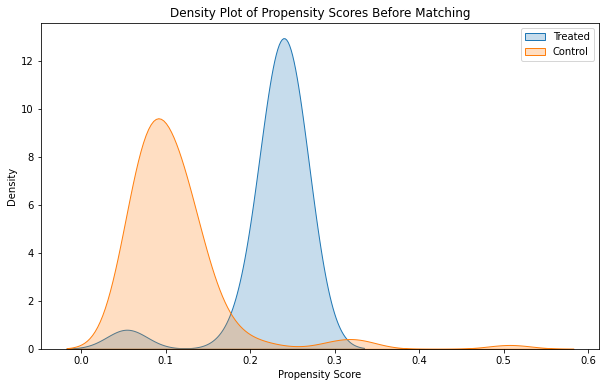

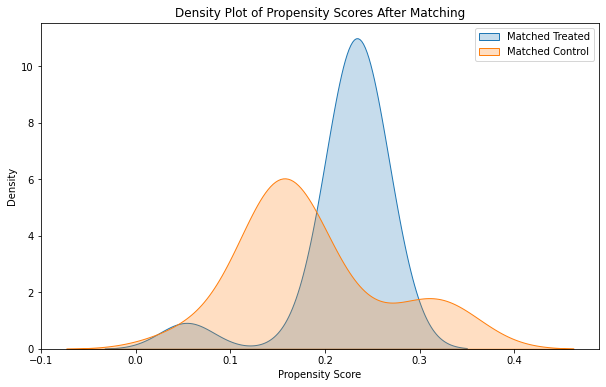

AUC score for propensity score model: 91.0%


Grouped by dataset                                               
                           Missing      Overall  Eran_Elinav      MetaHit P-Value
n                                            30           15           15        
Age, mean (SD)                   0  35.7 (12.0)  32.7 (10.9)  38.8 (12.7)   0.166

In [26]:
column_mapping = {"Age" : "Age"}

matched_treatment, matched_control, auc_score = propensity_score_matching(Eran_Elinav_alpha[Eran_Elinav_alpha["Disease"] == 'nonIBD'], MetaHit_alpha[MetaHit_alpha["diagnosis"] == 'nonIBD'],
                                                                          column_mapping, "Eran_Elinav", "MetaHit", matching_ratio=5, keep_size_by_small = 1.35)

# Extract propensity scores from matched datasets
matched_treated_scores = matched_treatment['propensity_score']
matched_control_scores = matched_control['propensity_score']

plt.figure(figsize=(10, 6))
sns.kdeplot(matched_treated_scores, shade=True, label='Matched Treated')
sns.kdeplot(matched_control_scores, shade=True, label='Matched Control')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Density Plot of Propensity Scores After Matching')
plt.legend()
plt.show()

print(f'AUC score for propensity score model: {round(auc_score,2)*100}%')
table_one_compare(matched_treatment, matched_control,"Eran_Elinav","MetaHit", column_mapping)


In [22]:
column_mapping = {"sex":"Gender", "age_at_consent" : "Age",  "Alpha_Diversity":"Alpha_Diversity"}
table_one_compare(ibdmdb_alpha[ibdmdb_alpha["diagnosis"] == 'nonIBD'], Eran_Elinav_alpha[Eran_Elinav_alpha["Disease"] == 'nonIBD'], "ibdmdb","Eran_Elinav", column_mapping)

Grouped by dataset                                              
                                             Missing      Overall Eran_Elinav       ibdmdb P-Value
n                                                              45          21           24        
sex, n (%)                 female                  0    21 (46.7)    9 (42.9)    12 (50.0)   0.857
                           male                         24 (53.3)   12 (57.1)    12 (50.0)        
age_at_consent, mean (SD)                          0  30.1 (16.1)  31.2 (9.4)  29.1 (20.4)   0.645
Alpha_Diversity, mean (SD)                         0    4.0 (1.1)   5.0 (0.4)    3.1 (0.7)  <0.001

caliper score: 0.24


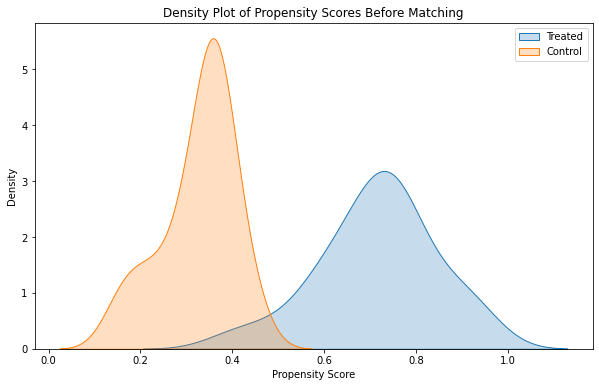

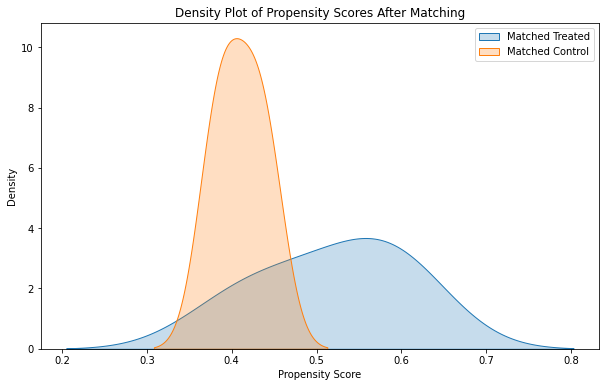

AUC score for propensity score model: 100.0%


Grouped by dataset                                          
                                       Missing    Overall Eran_Elinav     ibdmdb P-Value
n                                                       8           4          4        
Alpha_Diversity, mean (SD)                   0  4.3 (0.4)   4.6 (0.1)  4.1 (0.4)   0.085

In [27]:
column_mapping = {"Alpha_Diversity":"Alpha_Diversity"}

matched_treatment, matched_control, auc_score = propensity_score_matching(ibdmdb_alpha[ibdmdb_alpha["diagnosis"] == 'nonIBD'],
                                                                          Eran_Elinav_alpha[Eran_Elinav_alpha["Disease"] == 'nonIBD'],column_mapping, "ibdmdb","Eran_Elinav",
                                                                          matching_ratio=1, keep_size_by_small = 5)

# Extract propensity scores from matched datasets
matched_treated_scores = matched_treatment['propensity_score']
matched_control_scores = matched_control['propensity_score']

plt.figure(figsize=(10, 6))
sns.kdeplot(matched_treated_scores, shade=True, label='Matched Treated')
sns.kdeplot(matched_control_scores, shade=True, label='Matched Control')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Density Plot of Propensity Scores After Matching')
plt.legend()
plt.show()

print(f'AUC score for propensity score model: {round(auc_score,2)*100}%')
table_one_compare(matched_treatment, matched_control,"ibdmdb", "Eran_Elinav",column_mapping)


In [24]:
column_mapping = {"host_sex":"Gender", "Alpha_Diversity":"Alpha_Diversity"}
table_one_compare(HMP1_alpha, Eran_Elinav_alpha[Eran_Elinav_alpha["Disease"] == 'nonIBD'], "HMP1","Eran_Elinav", column_mapping)

Grouped by dataset                                          
                                             Missing    Overall Eran_Elinav       HMP1 P-Value
n                                                           161          21        140        
host_sex, n (%)            female                  0  70 (43.5)    9 (42.9)  61 (43.6)   1.000
                           male                       91 (56.5)   12 (57.1)  79 (56.4)        
Alpha_Diversity, mean (SD)                         0  3.4 (1.1)   5.0 (0.4)  3.2 (1.0)  <0.001

In [25]:
column_mapping = {"Gender" : "Gender", "Alpha_Diversity":"Alpha_Diversity"}
table_one_compare(HMP1_alpha, HMP2_alpha,"HMP1","HMP2", column_mapping)

Grouped by dataset                                          
                                             Missing     Overall       HMP1       HMP2 P-Value
n                                                            233        140         93        
Gender, n (%)              female                  0  107 (45.9)  61 (43.6)  46 (49.5)   0.454
                           male                       126 (54.1)  79 (56.4)  47 (50.5)        
Alpha_Diversity, mean (SD)                         0   3.2 (1.0)  3.2 (1.0)  3.2 (0.9)   0.968